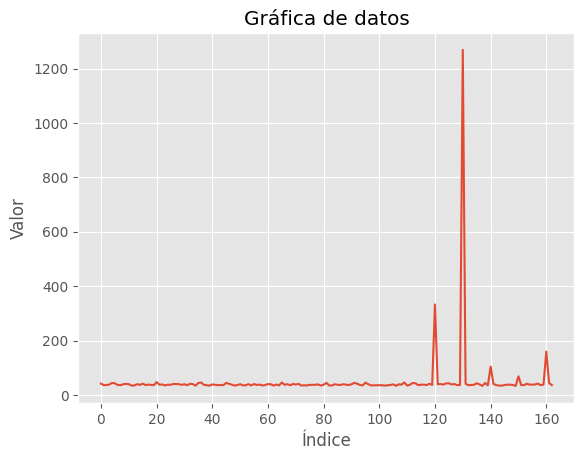

In [11]:
import numpy as np

# Cargar el archivo .npy
datos = np.load('rewards_contra.npy')  # Reemplaza con tu ruta real


import matplotlib.pyplot as plt

plt.plot(datos)
plt.title("Gráfica de datos")
plt.xlabel("Índice")
plt.ylabel("Valor")
plt.grid(True)
plt.show()

Total de episodios: 163


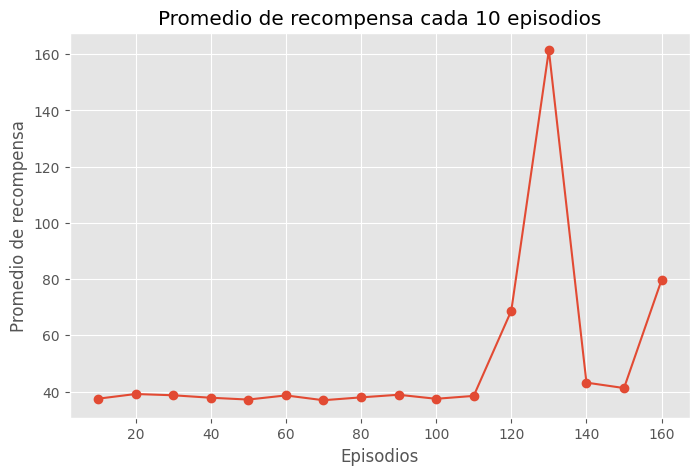

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Carga tu archivo .npy (por ejemplo "rewards.npy")
rewards = np.load("rewards_contra.npy")  # Cambia el nombre si es necesario

# Verifica el tamaño del array
print(f"Total de episodios: {len(rewards)}")

# Calcula el promedio de cada bloque de 10 episodios
promedios_por_10 = []
for i in range(0, len(rewards), 10):
  if i == 0:
    continue
  bloque = rewards[i:i+10]
  promedio = np.mean(bloque)
  promedios_por_10.append(promedio)

# Eje X: Episodios (cada punto representa el centro del bloque de 10)
x = np.arange(10, len(rewards), 10)

# Graficar
plt.figure(figsize=(8, 5))
plt.plot(x, promedios_por_10, marker='o')
plt.title("Promedio de recompensa cada 10 episodios")
plt.xlabel("Episodios")
plt.ylabel("Promedio de recompensa")
plt.grid(True)
plt.show()


## Tetris

In [ ]:
import numpy as np
from PIL import Image
import cv2
from matplotlib import style
import torch
import random

style.use("ggplot")


class Tetris:
    piece_colors = [
        (0, 0, 0),
        (255, 255, 0),
        (147, 88, 254),
        (54, 175, 144),
        (255, 0, 0),
        (102, 217, 238),
        (254, 151, 32),
        (0, 0, 255)
    ]

    pieces = [
        [[1, 1],
         [1, 1]],

        [[0, 2, 0],
         [2, 2, 2]],

        [[0, 3, 3],
         [3, 3, 0]],

        [[4, 4, 0],
         [0, 4, 4]],

        [[5, 5, 5, 5]],

        [[0, 0, 6],
         [6, 6, 6]],

        [[7, 0, 0],
         [7, 7, 7]]
    ]

    def __init__(self, height=20, width=10, block_size=20):
        self.height = height
        self.width = width
        self.block_size = block_size
        self.extra_board = np.ones((self.height * self.block_size, self.width * int(self.block_size / 2), 3),
                                   dtype=np.uint8) * np.array([204, 204, 255], dtype=np.uint8)
        self.text_color = (200, 20, 220)
        self.reset()

    def reset(self):
        self.board = [[0] * self.width for _ in range(self.height)]
        self.score = 0
        self.tetrominoes = 0
        self.cleared_lines = 0
        self.bag = list(range(len(self.pieces)))
        random.shuffle(self.bag)
        self.ind = self.bag.pop()
        self.piece = [row[:] for row in self.pieces[self.ind]]
        self.current_pos = {"x": self.width // 2 - len(self.piece[0]) // 2, "y": 0}
        self.gameover = False
        return self.get_state_properties(self.board)

    def rotate(self, piece):
        num_rows_orig = num_cols_new = len(piece)
        num_rows_new = len(piece[0])
        rotated_array = []

        for i in range(num_rows_new):
            new_row = [0] * num_cols_new
            for j in range(num_cols_new):
                new_row[j] = piece[(num_rows_orig - 1) - j][i]
            rotated_array.append(new_row)
        return rotated_array

    def get_state_properties(self, board):
        lines_cleared, board = self.check_cleared_rows(board)
        holes = self.get_holes(board)
        bumpiness, height = self.get_bumpiness_and_height(board)
        return torch.tensor([lines_cleared, holes, bumpiness, height], dtype=torch.float32)

    def get_holes(self, board):
        num_holes = 0
        for col in zip(*board):
            row = 0
            while row < self.height and col[row] == 0:
                row += 1
            num_holes += len([x for x in col[row + 1:] if x == 0])
        return num_holes

    def get_bumpiness_and_height(self, board):
        board = np.array(board)
        mask = board != 0
        invert_heights = np.where(mask.any(axis=0), np.argmax(mask, axis=0), self.height)
        heights = self.height - invert_heights
        total_height = np.sum(heights)
        currs = heights[:-1]
        nexts = heights[1:]
        diffs = np.abs(currs - nexts)
        total_bumpiness = np.sum(diffs)
        return total_bumpiness, total_height

    def get_next_states(self):
        states = {}
        piece_id = self.ind
        curr_piece = [row[:] for row in self.piece]
        num_rotations = 1 if piece_id == 0 else (2 if piece_id in [2, 3, 4] else 4)

        for i in range(num_rotations):
            valid_xs = self.width - len(curr_piece[0])
            for x in range(valid_xs + 1):
                piece = [row[:] for row in curr_piece]
                pos = {"x": x, "y": 0}
                while not self.check_collision(piece, pos):
                    pos["y"] += 1
                self.truncate(piece, pos)
                board = self.store(piece, pos)
                states[(x, i)] = self.get_state_properties(board)
            curr_piece = self.rotate(curr_piece)
        return states

    def get_current_board_state(self):
        board = [x[:] for x in self.board]
        for y in range(len(self.piece)):
            for x in range(len(self.piece[y])):
                board[y + self.current_pos["y"]][x + self.current_pos["x"]] = self.piece[y][x]
        return board

    def new_piece(self):
        if not len(self.bag):
            self.bag = list(range(len(self.pieces)))
            random.shuffle(self.bag)
        self.ind = self.bag.pop()
        self.piece = [row[:] for row in self.pieces[self.ind]]
        self.current_pos = {"x": self.width // 2 - len(self.piece[0]) // 2, "y": 0}
        if self.check_collision(self.piece, self.current_pos):
            self.gameover = True

    def check_collision(self, piece, pos):
        future_y = pos["y"] + 1
        for y in range(len(piece)):
            for x in range(len(piece[y])):
                if future_y + y > self.height - 1 or self.board[future_y + y][pos["x"] + x] and piece[y][x]:
                    return True
        return False

    def truncate(self, piece, pos):
        gameover = False
        last_collision_row = -1
        for y in range(len(piece)):
            for x in range(len(piece[y])):
                if self.board[pos["y"] + y][pos["x"] + x] and piece[y][x]:
                    if y > last_collision_row:
                        last_collision_row = y

        if pos["y"] - (len(piece) - last_collision_row) < 0 and last_collision_row > -1:
            while last_collision_row >= 0 and len(piece) > 1:
                gameover = True
                last_collision_row = -1
                del piece[0]
                for y in range(len(piece)):
                    for x in range(len(piece[y])):
                        if self.board[pos["y"] + y][pos["x"] + x] and piece[y][x] and y > last_collision_row:
                            last_collision_row = y
        return gameover

    def store(self, piece, pos):
        board = [x[:] for x in self.board]
        for y in range(len(piece)):
            for x in range(len(piece[y])):
                if piece[y][x] and not board[y + pos["y"]][x + pos["x"]]:
                    board[y + pos["y"]][x + pos["x"]] = piece[y][x]
        return board

    def check_cleared_rows(self, board):
        to_delete = [len(board) - 1 - i for i, row in enumerate(board[::-1]) if 0 not in row]
        if to_delete:
            board = self.remove_row(board, to_delete)
        return len(to_delete), board

    def remove_row(self, board, indices):
        for i in indices[::-1]:
            del board[i]
            board = [[0 for _ in range(self.width)]] + board
        return board

    def step(self, action, render=True, video=None):
        x, num_rotations = action
        self.current_pos = {"x": x, "y": 0}
        for _ in range(num_rotations):
            self.piece = self.rotate(self.piece)

        while not self.check_collision(self.piece, self.current_pos):
            self.current_pos["y"] += 1
            if render:
                self.render(video)

        overflow = self.truncate(self.piece, self.current_pos)
        if overflow:
            self.gameover = True

        self.board = self.store(self.piece, self.current_pos)
        lines_cleared, self.board = self.check_cleared_rows(self.board)
        score = 1 + (lines_cleared ** 2) * self.width
        self.score += score
        self.tetrominoes += 1
        self.cleared_lines += lines_cleared
        if not self.gameover:
            self.new_piece()
        else:
            self.score -= 2
        return score, self.gameover

    def render(self, video=None):
        img_data = self.get_current_board_state() if not self.gameover else self.board
        img = [self.piece_colors[p] for row in img_data for p in row]
        img = np.array(img).reshape((self.height, self.width, 3)).astype(np.uint8)
        img = img[..., ::-1]
        img = Image.fromarray(img, "RGB")
        img = img.resize((self.width * self.block_size, self.height * self.block_size), Image.NEAREST)
        img = np.array(img)
        img[[i * self.block_size for i in range(self.height)], :, :] = 0
        img[:, [i * self.block_size for i in range(self.width)], :] = 0
        img = np.concatenate((img, self.extra_board), axis=1)

        cv2.putText(img, "Score:", (self.width * self.block_size + int(self.block_size / 2), self.block_size),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1.0, color=self.text_color)
        cv2.putText(img, str(self.score),
                    (self.width * self.block_size + int(self.block_size / 2), 2 * self.block_size),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1.0, color=self.text_color)
        cv2.putText(img, "Pieces:", (self.width * self.block_size + int(self.block_size / 2), 4 * self.block_size),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1.0, color=self.text_color)
        cv2.putText(img, str(self.tetrominoes),
                    (self.width * self.block_size + int(self.block_size / 2), 5 * self.block_size),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1.0, color=self.text_color)
        cv2.putText(img, "Lines:", (self.width * self.block_size + int(self.block_size / 2), 7 * self.block_size),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1.0, color=self.text_color)
        cv2.putText(img, str(self.cleared_lines),
                    (self.width * self.block_size + int(self.block_size / 2), 8 * self.block_size),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1.0, color=self.text_color)

        if video:
            video.write(img)

        cv2.imshow("Deep Q-Learning Tetris", img)
        cv2.waitKey(1)

    def close(self):
        cv2.destroyAllWindows()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepQNetwork(nn.Module):
    def __init__(self):
        super(DeepQNetwork, self).__init__()

        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

        self._create_weights()

    def _create_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
import cv2
#from src.tetris import Tetris

def play():
    env = Tetris(width=10, height=20, block_size=30)
    env.reset()

    key_actions = {
        ord('a'): 'left',
        ord('d'): 'right',
        ord('s'): 'down',
        ord('w'): 'rotate',
        ord('q'): 'quit'
    }

    print("Controles:")
    print("a = izquierda, d = derecha, s = abajo, w = rotar, q = salir")

    while True:
        env.render()

        key = cv2.waitKey(0)

        if key in key_actions:
            action = key_actions[key]

            if action == 'left':
                env.current_pos['x'] = max(env.current_pos['x'] - 1, 0)
                if env.check_collision(env.piece, env.current_pos):
                    env.current_pos['x'] += 1

            elif action == 'right':
                env.current_pos['x'] = min(env.current_pos['x'] + 1, env.width - len(env.piece[0]))
                if env.check_collision(env.piece, env.current_pos):
                    env.current_pos['x'] -= 1

            elif action == 'down':
                env.current_pos['y'] += 1
                if env.check_collision(env.piece, env.current_pos):
                    env.current_pos['y'] -= 1
                    env.step((env.current_pos['x'], 0), render=True)

            elif action == 'rotate':
                rotated = env.rotate(env.piece)
                if not env.check_collision(rotated, env.current_pos):
                    env.piece = rotated

            elif action == 'quit':
                print("Juego terminado.")
                break

        if env.gameover:
            print("¡Game Over! Puntuación final:", env.score)
            cv2.waitKey(0)
            break

    cv2.destroyAllWindows()

if __name__ == "__main__":
    play()


AttributeError: 'builtin_function_or_method' object has no attribute 'shuffle'

## Main

In [ ]:
import argparse
import os
import shutil
from random import random, randint, sample
from collections import deque

import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

#from src.deep_q_network import DeepQNetwork
#from src.tetris import Tetris


def get_args():
    parser = argparse.ArgumentParser("DQN Training for Tetris")
    parser.add_argument("--width", type=int, default=10)
    parser.add_argument("--height", type=int, default=20)
    parser.add_argument("--block_size", type=int, default=30)
    parser.add_argument("--batch_size", type=int, default=512)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--gamma", type=float, default=0.99)
    parser.add_argument("--initial_epsilon", type=float, default=1.0)
    parser.add_argument("--final_epsilon", type=float, default=1e-3)
    parser.add_argument("--num_decay_epochs", type=float, default=2000)
    parser.add_argument("--num_epochs", type=int, default=3000)
    parser.add_argument("--save_interval", type=int, default=1000)
    parser.add_argument("--replay_memory_size", type=int, default=30000)
    parser.add_argument("--log_path", type=str, default="tensorboard")
    parser.add_argument("--saved_path", type=str, default="trained_models")
    return parser.parse_args()


def train(opt):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(123)
    if device.type == 'cuda':
        torch.cuda.manual_seed(123)

    # Limpieza de logs previos
    if os.path.isdir(opt.log_path):
        shutil.rmtree(opt.log_path)
    os.makedirs(opt.log_path, exist_ok=True)
    writer = SummaryWriter(opt.log_path)

    env = Tetris(width=opt.width, height=opt.height, block_size=opt.block_size)
    model = DeepQNetwork().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=opt.lr)
    criterion = nn.MSELoss()

    state = env.reset().to(device)
    replay_memory = deque(maxlen=opt.replay_memory_size)

    epoch = 0
    while epoch < opt.num_epochs:
        next_steps = env.get_next_states()

        # ε-greedy exploration
        epsilon = opt.final_epsilon + max(opt.num_decay_epochs - epoch, 0) * (opt.initial_epsilon - opt.final_epsilon) / opt.num_decay_epochs
        u = random()
        random_action = u <= epsilon

        next_actions, next_states = zip(*next_steps.items())
        next_states = torch.stack(next_states).to(device)

        model.eval()
        with torch.no_grad():
            predictions = model(next_states).squeeze(-1)
        model.train()

        if random_action:
            index = randint(0, len(next_steps) - 1)
        else:
            index = torch.argmax(predictions).item()

        next_state = next_states[index]
        action = next_actions[index]

        reward, done = env.step(action, render=True)

        replay_memory.append([state, reward, next_state, done])

        if done:
            final_score = env.score
            final_tetrominoes = env.tetrominoes
            final_cleared_lines = env.cleared_lines

            state = env.reset().to(device)
        else:
            state = next_state
            continue

        # Solo empezar entrenamiento cuando haya suficiente en el buffer
        if len(replay_memory) < opt.replay_memory_size / 10:
            continue

        epoch += 1
        batch = sample(replay_memory, min(len(replay_memory), opt.batch_size))
        state_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

        state_batch = torch.stack(state_batch).to(device)
        reward_batch = torch.tensor(reward_batch, dtype=torch.float32, device=device).unsqueeze(1)
        next_state_batch = torch.stack(next_state_batch).to(device)

        q_values = model(state_batch)

        model.eval()
        with torch.no_grad():
            next_q_values = model(next_state_batch)
        model.train()

        y_batch = torch.cat([
            reward.unsqueeze(0) if done else reward.unsqueeze(0) + opt.gamma * next_q_val.unsqueeze(0)
            for reward, done, next_q_val in zip(reward_batch, done_batch, next_q_values)
        ], dim=0)

        optimizer.zero_grad()
        loss = criterion(q_values, y_batch)
        loss.backward()
        optimizer.step()

        print(f"Epoch: {epoch}/{opt.num_epochs}, Action: {action}, Score: {final_score}, Tetrominoes: {final_tetrominoes}, Lines: {final_cleared_lines}")
        writer.add_scalar('Train/Score', final_score, epoch - 1)
        writer.add_scalar('Train/Tetrominoes', final_tetrominoes, epoch - 1)
        writer.add_scalar('Train/Cleared_lines', final_cleared_lines, epoch - 1)

        if epoch > 0 and epoch % opt.save_interval == 0:
            os.makedirs(opt.saved_path, exist_ok=True)
            torch.save(model.state_dict(), f"{opt.saved_path}/tetris_{epoch}.pth")

    torch.save(model.state_dict(), f"{opt.saved_path}/tetris_final.pth")


if __name__ == "__main__":
    opt = get_args()
    train(opt)


usage: DQN Training for Tetris [-h] [--width WIDTH] [--height HEIGHT]
                               [--block_size BLOCK_SIZE]
                               [--batch_size BATCH_SIZE] [--lr LR]
                               [--gamma GAMMA]
                               [--initial_epsilon INITIAL_EPSILON]
                               [--final_epsilon FINAL_EPSILON]
                               [--num_decay_epochs NUM_DECAY_EPOCHS]
                               [--num_epochs NUM_EPOCHS]
                               [--save_interval SAVE_INTERVAL]
                               [--replay_memory_size REPLAY_MEMORY_SIZE]
                               [--log_path LOG_PATH] [--saved_path SAVED_PATH]
DQN Training for Tetris: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-06703759-6b32-4b55-9bfb-9ef6e9371038.json


SystemExit: 2

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
import argparse
import torch
import cv2
from src.deep_q_network import DeepQNetwork
from src.tetris import Tetris


def get_args():
    parser = argparse.ArgumentParser("DQN Tetris Inference")
    parser.add_argument("--width", type=int, default=10)
    parser.add_argument("--height", type=int, default=20)
    parser.add_argument("--block_size", type=int, default=30)
    parser.add_argument("--fps", type=int, default=30)
    parser.add_argument("--saved_model", type=str, default="trained_models/tetris_final.pth")
    parser.add_argument("--output", type=str, default="output.mp4")
    return parser.parse_args()


def test(opt):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(123)
    if device.type == 'cuda':
        torch.cuda.manual_seed(123)

    # Cargar modelo
    model = DeepQNetwork().to(device)
    model.load_state_dict(torch.load(opt.saved_model, map_location=device))
    model.eval()

    env = Tetris(width=opt.width, height=opt.height, block_size=opt.block_size)
    env.reset()

    frame_size = (int(1.5 * opt.width * opt.block_size), opt.height * opt.block_size)
    out = cv2.VideoWriter(opt.output, cv2.VideoWriter_fourcc(*"MJPG"), opt.fps, frame_size)

    while True:
        next_steps = env.get_next_states()
        next_actions, next_states = zip(*next_steps.items())
        next_states = torch.stack(next_states).to(device)

        with torch.no_grad():
            predictions = model(next_states).squeeze(-1)
        index = torch.argmax(predictions).item()
        action = next_actions[index]

        _, done = env.step(action, render=True, video=out)

        if done:
            out.release()
            break


if __name__ == "__main__":
    opt = get_args()
    test(opt)


## Con Target Network

In [ ]:
"""
@author: Viet Nguyen <nhviet1009@gmail.com>
Modificado por ChatGPT para incluir Target Network
"""

import argparse
import os
import shutil
from random import random, randint, sample
from collections import deque

import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from src.deep_q_network import DeepQNetwork
from src.tetris import Tetris


def get_args():
    parser = argparse.ArgumentParser(
        """Implementation of Deep Q Network to play Tetris con target network""")
    parser.add_argument("--width", type=int, default=10, help="Width del tablero")
    parser.add_argument("--height", type=int, default=20, help="Height del tablero")
    parser.add_argument("--block_size", type=int, default=30, help="Tamaño de bloque")
    parser.add_argument("--batch_size", type=int, default=512)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--gamma", type=float, default=0.99)
    parser.add_argument("--initial_epsilon", type=float, default=1.0)
    parser.add_argument("--final_epsilon", type=float, default=1e-3)
    parser.add_argument("--num_decay_epochs", type=float, default=2000)
    parser.add_argument("--num_epochs", type=int, default=3000)
    parser.add_argument("--save_interval", type=int, default=1000)
    parser.add_argument("--replay_memory_size", type=int, default=30000)
    parser.add_argument("--log_path", type=str, default="tensorboard")
    parser.add_argument("--saved_path", type=str, default="trained_models")
    parser.add_argument("--target_update_interval", type=int, default=100, help="Epochs entre updates de target network")
    args = parser.parse_args()
    return args


def train(opt):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(123)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(123)

    # Limpiar logs anteriores
    if os.path.isdir(opt.log_path):
        shutil.rmtree(opt.log_path)
    os.makedirs(opt.log_path)

    writer = SummaryWriter(opt.log_path)
    env = Tetris(width=opt.width, height=opt.height, block_size=opt.block_size)
    model = DeepQNetwork().to(device)
    target_model = DeepQNetwork().to(device)
    target_model.load_state_dict(model.state_dict())
    target_model.eval()

    optimizer = torch.optim.Adam(model.parameters(), lr=opt.lr)
    criterion = nn.MSELoss()

    state = env.reset().to(device)
    replay_memory = deque(maxlen=opt.replay_memory_size)

    epoch = 0
    while epoch < opt.num_epochs:
        next_steps = env.get_next_states()
        next_actions, next_states = zip(*next_steps.items())
        next_states = torch.stack(next_states).to(device)

        # Exploración o explotación
        epsilon = opt.final_epsilon + (max(opt.num_decay_epochs - epoch, 0) *
                                       (opt.initial_epsilon - opt.final_epsilon) / opt.num_decay_epochs)
        u = random()
        random_action = u <= epsilon

        model.eval()
        with torch.no_grad():
            predictions = model(next_states)[:, 0]
        model.train()

        if random_action:
            index = randint(0, len(next_steps) - 1)
        else:
            index = torch.argmax(predictions).item()

        next_state = next_states[index, :]
        action = next_actions[index]

        reward, done = env.step(action, render=True)

        replay_memory.append([state, reward, next_state, done])

        if done:
            final_score = env.score
            final_tetrominoes = env.tetrominoes
            final_cleared_lines = env.cleared_lines
            state = env.reset().to(device)
        else:
            state = next_state
            continue

        # Solo entrenar si ya hay suficiente memoria
        if len(replay_memory) < opt.replay_memory_size / 10:
            continue

        epoch += 1

        # Muestra el progreso
        print(f"Epoch: {epoch}/{opt.num_epochs}, Action: {action}, Score: {final_score}, "
              f"Tetrominoes: {final_tetrominoes}, Cleared lines: {final_cleared_lines}")

        # Sampling batch
        batch = sample(replay_memory, min(len(replay_memory), opt.batch_size))
        state_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

        state_batch = torch.stack(state_batch).to(device)
        reward_batch = torch.from_numpy(np.array(reward_batch, dtype=np.float32)[:, None]).to(device)
        next_state_batch = torch.stack(next_state_batch).to(device)

        # Predicciones actuales
        q_values = model(state_batch)

        # Predicción de siguiente estado usando target network
        model.eval()
        with torch.no_grad():
            next_prediction_batch = target_model(next_state_batch)
        model.train()

        # Cálculo de targets
        y_batch = torch.cat(
            tuple(
                reward if done else reward + opt.gamma * prediction
                for reward, done, prediction in zip(reward_batch, done_batch, next_prediction_batch)
            )
        )[:, None]

        # Backpropagation
        optimizer.zero_grad()
        loss = criterion(q_values, y_batch)
        loss.backward()
        optimizer.step()

        # Actualizar target network cada N epochs
        if epoch % opt.target_update_interval == 0:
            target_model.load_state_dict(model.state_dict())

        # Log en TensorBoard
        writer.add_scalar('Train/Score', final_score, epoch - 1)
        writer.add_scalar('Train/Tetrominoes', final_tetrominoes, epoch - 1)
        writer.add_scalar('Train/Cleared lines', final_cleared_lines, epoch - 1)

        # Guardar modelo cada N epochs
        if epoch > 0 and epoch % opt.save_interval == 0:
            torch.save(model, os.path.join(opt.saved_path, f"tetris_{epoch}"))

    torch.save(model, os.path.join(opt.saved_path, "tetris"))


if __name__ == "__main__":
    opt = get_args()
    train(opt)


probado

In [ ]:
import argparse
import os
import shutil
from random import random, randint, sample
from collections import deque

import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from src.deep_q_network import DeepQNetwork
from src.tetris import Tetris


def get_args():
    parser = argparse.ArgumentParser("DQN Training for Tetris")
    parser.add_argument("--width", type=int, default=10)
    parser.add_argument("--height", type=int, default=20)
    parser.add_argument("--block_size", type=int, default=30)
    parser.add_argument("--batch_size", type=int, default=512)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--gamma", type=float, default=0.99)
    parser.add_argument("--initial_epsilon", type=float, default=1.0)
    parser.add_argument("--final_epsilon", type=float, default=1e-3)
    parser.add_argument("--num_decay_epochs", type=float, default=2000)
    parser.add_argument("--num_epochs", type=int, default=3000)
    parser.add_argument("--save_interval", type=int, default=1000)
    parser.add_argument("--replay_memory_size", type=int, default=30000)
    parser.add_argument("--log_path", type=str, default="tensorboard")
    parser.add_argument("--saved_path", type=str, default="trained_models")
    return parser.parse_args()


def train(opt):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(123)
    if device.type == 'cuda':
        torch.cuda.manual_seed(123)

    # Limpieza de logs previos
    if os.path.isdir(opt.log_path):
        shutil.rmtree(opt.log_path)
    os.makedirs(opt.log_path, exist_ok=True)
    writer = SummaryWriter(opt.log_path)

    env = Tetris(width=opt.width, height=opt.height, block_size=opt.block_size)
    model = DeepQNetwork().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=opt.lr)
    criterion = nn.MSELoss()

    state = env.reset().to(device)
    replay_memory = deque(maxlen=opt.replay_memory_size)

    epoch = 0
    while epoch < opt.num_epochs:
        next_steps = env.get_next_states()

        # ε-greedy exploration
        epsilon = opt.final_epsilon + max(opt.num_decay_epochs - epoch, 0) * (opt.initial_epsilon - opt.final_epsilon) / opt.num_decay_epochs
        u = random()
        random_action = u <= epsilon

        next_actions, next_states = zip(*next_steps.items())
        next_states = torch.stack(next_states).to(device)

        model.eval()
        with torch.no_grad():
            predictions = model(next_states).squeeze(-1)
        model.train()

        if random_action:
            index = randint(0, len(next_steps) - 1)
        else:
            index = torch.argmax(predictions).item()

        next_state = next_states[index]
        action = next_actions[index]

        reward, done = env.step(action, render=True)

        replay_memory.append([state, reward, next_state, done])

        if done:
            final_score = env.score
            final_tetrominoes = env.tetrominoes
            final_cleared_lines = env.cleared_lines

            state = env.reset().to(device)
        else:
            state = next_state
            continue

        # Solo empezar entrenamiento cuando haya suficiente en el buffer
        if len(replay_memory) < opt.replay_memory_size / 10:
            continue

        epoch += 1
        batch = sample(replay_memory, min(len(replay_memory), opt.batch_size))
        state_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

        state_batch = torch.stack(state_batch).to(device)
        reward_batch = torch.tensor(reward_batch, dtype=torch.float32, device=device).unsqueeze(1)
        next_state_batch = torch.stack(next_state_batch).to(device)

        q_values = model(state_batch)

        model.eval()
        with torch.no_grad():
            next_q_values = model(next_state_batch)
        model.train()

        y_batch = torch.cat([
            reward.unsqueeze(0) if done else reward.unsqueeze(0) + opt.gamma * next_q_val.unsqueeze(0)
            for reward, done, next_q_val in zip(reward_batch, done_batch, next_q_values)
        ], dim=0)

        optimizer.zero_grad()
        loss = criterion(q_values, y_batch)
        loss.backward()
        optimizer.step()

        print(f"Epoch: {epoch}/{opt.num_epochs}, Action: {action}, Score: {final_score}, Tetrominoes: {final_tetrominoes}, Lines: {final_cleared_lines}")
        writer.add_scalar('Train/Score', final_score, epoch - 1)
        writer.add_scalar('Train/Tetrominoes', final_tetrominoes, epoch - 1)
        writer.add_scalar('Train/Cleared_lines', final_cleared_lines, epoch - 1)

        if epoch > 0 and epoch % opt.save_interval == 0:
            os.makedirs(opt.saved_path, exist_ok=True)
            torch.save(model.state_dict(), f"{opt.saved_path}/tetris_{epoch}.pth")

    torch.save(model.state_dict(), f"{opt.saved_path}/tetris_final.pth")


if __name__ == "__main__":
    opt = get_args()
    train(opt)


final

In [ ]:
"""
@author: Viet Nguyen
Modificado por ChatGPT para incluir Target Network y guardar el mejor modelo
"""

import argparse
import os
import shutil
from random import random, randint, sample
from collections import deque

import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from src.deep_q_network import DeepQNetwork
from src.tetris import Tetris


def get_args():
    parser = argparse.ArgumentParser(
        """Implementation of Deep Q Network to play Tetris con target network y best model saving""")
    parser.add_argument("--width", type=int, default=10, help="Width del tablero")
    parser.add_argument("--height", type=int, default=20, help="Height del tablero")
    parser.add_argument("--block_size", type=int, default=30, help="Tamaño de bloque")
    parser.add_argument("--batch_size", type=int, default=512)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--gamma", type=float, default=0.99)
    parser.add_argument("--initial_epsilon", type=float, default=1.0)
    parser.add_argument("--final_epsilon", type=float, default=1e-3)
    parser.add_argument("--num_decay_epochs", type=float, default=2000)
    parser.add_argument("--num_epochs", type=int, default=3000)
    parser.add_argument("--save_interval", type=int, default=1000)
    parser.add_argument("--replay_memory_size", type=int, default=30000)
    parser.add_argument("--log_path", type=str, default="tensorboard")
    parser.add_argument("--saved_path", type=str, default="trained_models")
    parser.add_argument("--target_update_interval", type=int, default=100, help="Epochs entre updates de target network")
    args = parser.parse_args()
    return args


def train(opt):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(123)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(123)

    # Limpiar logs anteriores
    if os.path.isdir(opt.log_path):
        shutil.rmtree(opt.log_path)
    os.makedirs(opt.log_path)

    writer = SummaryWriter(opt.log_path)
    env = Tetris(width=opt.width, height=opt.height, block_size=opt.block_size)
    model = DeepQNetwork().to(device)
    target_model = DeepQNetwork().to(device)
    target_model.load_state_dict(model.state_dict())
    target_model.eval()

    optimizer = torch.optim.Adam(model.parameters(), lr=opt.lr)
    criterion = nn.MSELoss()

    state = env.reset().to(device)
    replay_memory = deque(maxlen=opt.replay_memory_size)
    best_score = float('-inf')

    epoch = 0
    while epoch < opt.num_epochs:
        next_steps = env.get_next_states()
        next_actions, next_states = zip(*next_steps.items())
        next_states = torch.stack(next_states).to(device)

        # Exploración o explotación
        epsilon = opt.final_epsilon + (max(opt.num_decay_epochs - epoch, 0) *
                                       (opt.initial_epsilon - opt.final_epsilon) / opt.num_decay_epochs)
        u = random()
        random_action = u <= epsilon

        model.eval()
        with torch.no_grad():
            predictions = model(next_states)[:, 0]
        model.train()

        if random_action:
            index = randint(0, len(next_steps) - 1)
        else:
            index = torch.argmax(predictions).item()

        next_state = next_states[index, :]
        action = next_actions[index]

        reward, done = env.step(action, render=True)

        replay_memory.append([state, reward, next_state, done])

        if done:
            final_score = env.score
            final_tetrominoes = env.tetrominoes
            final_cleared_lines = env.cleared_lines
            state = env.reset().to(device)

            # Guardar mejor modelo si supera
            if final_score > best_score:
                best_score = final_score
                torch.save(model, os.path.join(opt.saved_path, "best_model.pth"))
                print(f"✔️ Nuevo mejor modelo guardado con score {best_score} en epoch {epoch}")

        else:
            state = next_state
            continue

        # Solo entrenar si ya hay suficiente memoria
        if len(replay_memory) < opt.replay_memory_size / 10:
            continue

        epoch += 1

        # Muestra el progreso
        print(f"Epoch: {epoch}/{opt.num_epochs}, Action: {action}, Score: {final_score}, "
              f"Tetrominoes: {final_tetrominoes}, Cleared lines: {final_cleared_lines}")

        # Sampling batch
        batch = sample(replay_memory, min(len(replay_memory), opt.batch_size))
        state_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

        state_batch = torch.stack(state_batch).to(device)
        reward_batch = torch.from_numpy(np.array(reward_batch, dtype=np.float32)[:, None]).to(device)
        next_state_batch = torch.stack(next_state_batch).to(device)

        # Predicciones actuales
        q_values = model(state_batch)

        # Predicción de siguiente estado usando target network
        model.eval()
        with torch.no_grad():
            next_prediction_batch = target_model(next_state_batch)
        model.train()

        # Cálculo de targets
        y_batch = torch.cat(
            tuple(
                reward if done else reward + opt.gamma * prediction
                for reward, done, prediction in zip(reward_batch, done_batch, next_prediction_batch)
            )
        )[:, None]

        # Backpropagation
        optimizer.zero_grad()
        loss = criterion(q_values, y_batch)
        loss.backward()
        optimizer.step()

        # Actualizar target network cada N epochs
        if epoch % opt.target_update_interval == 0:
            target_model.load_state_dict(model.state_dict())

        # Log en TensorBoard
        writer.add_scalar('Train/Score', final_score, epoch - 1)
        writer.add_scalar('Train/Tetrominoes', final_tetrominoes, epoch - 1)
        writer.add_scalar('Train/Cleared lines', final_cleared_lines, epoch - 1)

        # Guardar modelo cada N epochs
        if epoch > 0 and epoch % opt.save_interval == 0:
            torch.save(model, os.path.join(opt.saved_path, f"tetris_{epoch}"))

    torch.save(model, os.path.join(opt.saved_path, "tetris"))


if __name__ == "__main__":
    opt = get_args()
    os.makedirs(opt.saved_path, exist_ok=True)
    train(opt)
